In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             confusion_matrix, roc_auc_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [3]:
DATA_DIR = Path(r"C:\Users\mnlku\my personal\btech\internships\unified mentor\Mobile Phone Pricing\data")  
TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH  = DATA_DIR / "test.csv"   

assert TRAIN_PATH.exists(), f"Couldn't find {TRAIN_PATH}. Place Kaggle train.csv there."

In [4]:
df = pd.read_csv(TRAIN_PATH)
print("Shape:", df.shape)
print(df.head(3))

target_col = "price_range"
assert target_col in df.columns, f"{target_col} not found in train.csv columns."

print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False).head(10))

Shape: (2000, 21)
   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   

   three_g  touch_screen  wifi  price_range  
0        0             0     1            1  
1        1             1     0            2  
2        1             1     0            2  

[3 rows x 21 columns]

Missing values per column:
battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g    

In [5]:
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

num_cols = X.columns.tolist()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

In [6]:
preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_cols)],
    remainder="drop"
)


In [7]:
models = {
    "logreg": Pipeline(steps=[
        ("prep", preprocess),
        ("clf", LogisticRegression(max_iter=200, multi_class="multinomial", random_state=RANDOM_STATE))
    ]),
    "rf": Pipeline(steps=[
        ("prep", "passthrough"),
        ("clf", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1))
    ]),
    "gb": Pipeline(steps=[
        ("prep", "passthrough"),
        ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
    ])
}

In [8]:
def cv_score(model, X, y, folds=5):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
    accs, f1s = [], []
    for tr_idx, te_idx in skf.split(X, y):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        model.fit(X_tr, y_tr)
        pred = model.predict(X_te)
        accs.append(accuracy_score(y_te, pred))
        f1s.append(f1_score(y_te, pred, average="macro"))
    return np.mean(accs), np.std(accs), np.mean(f1s), np.std(f1s)

print("\n=== Baseline CV (5-fold) ===")
for name, pipe in models.items():
    acc_m, acc_s, f1_m, f1_s = cv_score(pipe, X_train, y_train, folds=5)
    print(f"{name:>6}: acc {acc_m:.4f}±{acc_s:.3f} | f1_macro {f1_m:.4f}±{f1_s:.3f}")



=== Baseline CV (5-fold) ===
logreg: acc 0.9481±0.010 | f1_macro 0.9480±0.010
    rf: acc 0.8713±0.031 | f1_macro 0.8706±0.032
    gb: acc 0.8881±0.019 | f1_macro 0.8884±0.019


In [9]:
search_spaces = {
    "logreg": {
        "clf__C": np.logspace(-2, 2, 20),
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs", "saga"]
    },
    "rf": {
        "clf__n_estimators": [200, 300, 400, 600],
        "clf__max_depth": [None, 6, 8, 10],
        "clf__min_samples_split": [2, 4, 6, 10],
        "clf__min_samples_leaf": [1, 2, 3],
        "clf__max_features": ["sqrt", "log2", None]
    },
    "gb": {
        "clf__n_estimators": [150, 250, 400],
        "clf__learning_rate": [0.03, 0.05, 0.08, 0.1],
        "clf__max_depth": [2, 3, 4],
        "clf__subsample": [0.8, 0.9, 1.0]
    }
}

best_models = {}
print("\n=== RandomizedSearchCV (stratified 5-fold) ===")
for name, pipe in models.items():
    param_distributions = search_spaces.get(name, {})
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=20,
        scoring="f1_macro",
        cv=5,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0
    )
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    print(f"{name:>6}: best f1_macro {search.best_score_:.4f}")



=== RandomizedSearchCV (stratified 5-fold) ===
logreg: best f1_macro 0.9624
    rf: best f1_macro 0.8862
    gb: best f1_macro 0.8982


In [10]:
val_scores = []
for name, model in best_models.items():
    pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, pred)
    f1m = f1_score(y_valid, pred, average="macro")
    val_scores.append((name, acc, f1m))
    print(f"VALID {name:>6}: acc={acc:.4f} | f1_macro={f1m:.4f}")

val_scores.sort(key=lambda t: t[2], reverse=True)
best_name, best_acc, best_f1 = val_scores[0]
best_model = best_models[best_name]
print(f"\n>>> Selected best model: {best_name} | acc={best_acc:.4f} | f1_macro={best_f1:.4f}")


VALID logreg: acc=0.9800 | f1_macro=0.9800
VALID     rf: acc=0.9000 | f1_macro=0.9002
VALID     gb: acc=0.9375 | f1_macro=0.9374

>>> Selected best model: logreg | acc=0.9800 | f1_macro=0.9800



Classification report (validation):
              precision    recall  f1-score   support

           0     0.9900    0.9900    0.9900       100
           1     0.9897    0.9600    0.9746       100
           2     0.9519    0.9900    0.9706       100
           3     0.9899    0.9800    0.9849       100

    accuracy                         0.9800       400
   macro avg     0.9804    0.9800    0.9800       400
weighted avg     0.9804    0.9800    0.9800       400



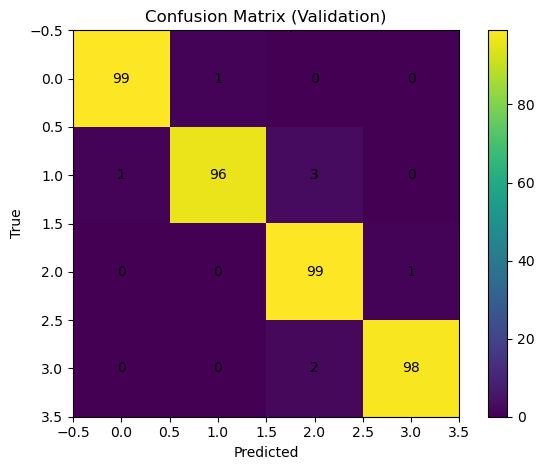

In [11]:
y_pred = best_model.predict(X_valid)
print("\nClassification report (validation):")
print(classification_report(y_valid, y_pred, digits=4))

cm = confusion_matrix(y_valid, y_pred)
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()


Permutation Importances...
          feature  importance_mean
13            ram         0.703906
0   battery_power         0.229199
12       px_width         0.120940
11      px_height         0.116067
8       mobile_wt         0.021907
6      int_memory         0.009982
9         n_cores         0.009002
7           m_dep         0.007254
14           sc_h         0.006539
10             pc         0.004507


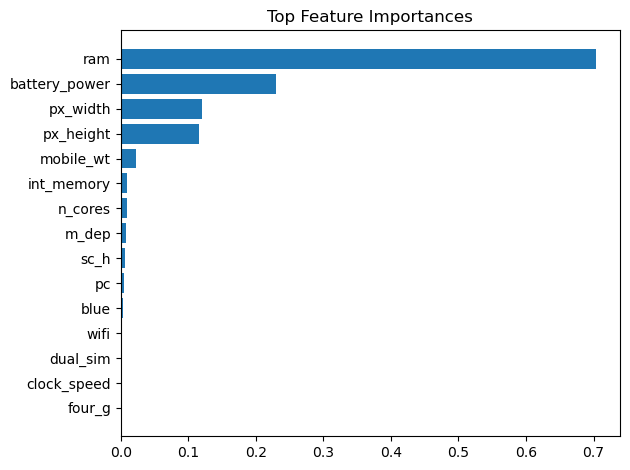

In [12]:
print("\nPermutation Importances...")
r = permutation_importance(best_model, X_valid, y_valid, scoring="f1_macro",
                           n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
imp_df = pd.DataFrame({"feature": X.columns, "importance_mean": r.importances_mean})
imp_df = imp_df.sort_values("importance_mean", ascending=False)
print(imp_df.head(10))

plt.barh(imp_df["feature"][:15][::-1], imp_df["importance_mean"][:15][::-1])
plt.title("Top Feature Importances")
plt.tight_layout()
plt.show()

In [13]:
best_model.fit(X, y)
EXPORT_DIR = Path("./export")
EXPORT_DIR.mkdir(exist_ok=True)
stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = EXPORT_DIR / f"mobile_price_best_model_{best_name}_{stamp}.joblib"
joblib.dump({"model": best_model, "features": X.columns.tolist(), "target": target_col}, model_path)
print(f"\nSaved best model to: {model_path}")


Saved best model to: export\mobile_price_best_model_logreg_20250903_140731.joblib


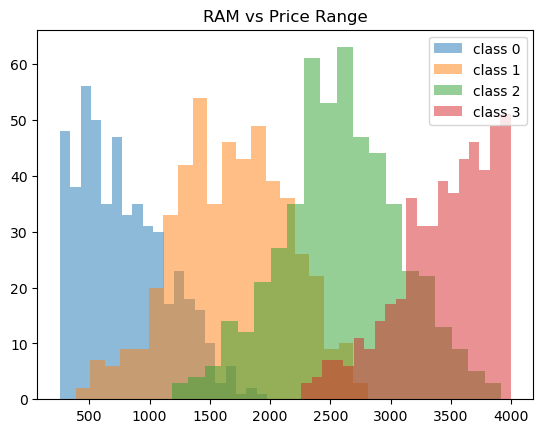


DONE ✅


In [14]:
plt.figure()
for cls in sorted(y.unique()):
    plt.hist(df[df[target_col]==cls]["ram"], alpha=0.5, bins=20, label=f"class {cls}")
plt.legend()
plt.title("RAM vs Price Range")
plt.show()

print("\nDONE ✅")

In [1]:
sample_phone = {
    "battery_power": 1500,   # mAh
    "blue": 1,               # Bluetooth: 1=yes, 0=no
    "clock_speed": 2.0,      # GHz
    "dual_sim": 1,           # Dual SIM
    "fc": 5,                 # Front Camera MP
    "four_g": 1,             # 4G: 1=yes, 0=no
    "int_memory": 32,        # Internal Memory (GB)
    "m_dep": 0.5,            # Mobile Depth (cm)
    "mobile_wt": 150,        # Weight (g)
    "n_cores": 4,            # Number of Cores
    "pc": 12,                # Primary Camera MP
    "px_height": 600,        # Pixel Resolution Height
    "px_width": 1000,        # Pixel Resolution Width
    "ram": 3000,             # RAM (MB)
    "sc_h": 12,              # Screen Height (cm)
    "sc_w": 7,               # Screen Width (cm)
    "talk_time": 12,         # Talk Time (hours)
    "three_g": 1,            # 3G: 1=yes, 0=no
    "touch_screen": 1,       # Touch Screen: 1=yes, 0=no
    "wifi": 1                # Wi-Fi: 1=yes, 0=no
}


In [2]:
sample_df = pd.DataFrame([sample_phone])


NameError: name 'pd' is not defined

In [3]:
pred_class = best_model.predict(sample_df)[0]
price_map = {0: "Low Cost", 1: "Medium Cost", 2: "High Cost", 3: "Very High Cost"}

print("Predicted Price Range:", pred_class, "→", price_map[pred_class])


NameError: name 'best_model' is not defined